## Import necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess the Data

In [2]:
transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor()])


In [3]:
train=ImageFolder("./seg_train/seg_train/",transform=transform)
len(train)

14034

In [4]:
stats = ((0.4951, 0.4982,0.4979), (0.2482,0.2467,0.2807))


In [5]:
train_dl=DataLoader(train,shuffle=True,num_workers=3,pin_memory=True)
def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data,dim=([0,2,3]))
        squared_sum += torch.mean(data**2, dim=([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches-mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean,std


(tensor([0.4302, 0.4575, 0.4539]), tensor([0.2480, 0.2467, 0.2806]))

In [6]:
len(train_dl)

14034

In [7]:
dataset=ImageFolder("./seg_train/seg_train/",transform=transform)
test_dir=ImageFolder("./seg_test/seg_test/",transform=transform)

In [8]:
len(dataset),len(test_dir)

(14034, 3000)

## Visualize some pictures

In [9]:
print(dataset.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [10]:
img,label=dataset[0]
print(img.shape,label)
print(img)

torch.Size([3, 64, 64]) 0
tensor([[[0.9686, 0.9686, 0.9725,  ..., 0.9765, 0.9725, 0.9686],
         [0.9647, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9686],
         [0.9686, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.2588, 0.2627, 0.2549,  ..., 0.3020, 0.3020, 0.2863],
         [0.2314, 0.3020, 0.2745,  ..., 0.2863, 0.2863, 0.2118],
         [0.2235, 0.3098, 0.2392,  ..., 0.1804, 0.1843, 0.1961]],

        [[0.9686, 0.9725, 0.9804,  ..., 0.9765, 0.9725, 0.9686],
         [0.9647, 0.9725, 0.9765,  ..., 0.9765, 0.9765, 0.9686],
         [0.9725, 0.9725, 0.9765,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.2510, 0.2510, 0.2471,  ..., 0.2824, 0.2824, 0.2667],
         [0.2275, 0.2980, 0.2706,  ..., 0.2667, 0.2667, 0.1922],
         [0.2196, 0.3059, 0.2353,  ..., 0.1608, 0.1647, 0.1765]],

        [[0.9608, 0.9647, 0.9686,  ..., 0.9765, 0.9725, 0.9647],
         [0.9569, 0.9608, 0.9647,  ..., 0.9765, 0.9765, 0.9647],
         [0.9608, 0.9647, 0.9647

In [11]:
matplotlib.rcParams['figure.facecolor']='#ffffff'

In [12]:
def img_show(img,label):
    print('Label ',dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label  buildings (0)


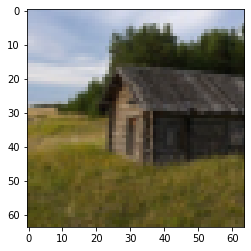

In [13]:
img_show(*dataset[99])

Label  buildings (0)


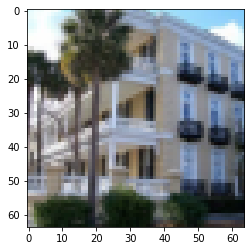

In [14]:
img_show(*dataset[999])

Label  buildings (0)


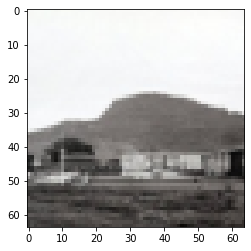

In [15]:
img_show(*dataset[0])

## Split the dataset in train and val set

In [16]:
random_seed=42
torch.manual_seed(random_seed)

In [17]:
val_size=3000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(11034, 3000)

## Creating Batches

In [18]:
batch_size=128

#laod the pytorch data
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=3,pin_memory=True)
test_dl=DataLoader(test_dir,batch_size*2,num_workers=3,pin_memory=True)



In [19]:
def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images *stds +means
def show_batches(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        denor_img=denormalize(images,*stats)
        ax.imshow(make_grid(denor_img[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

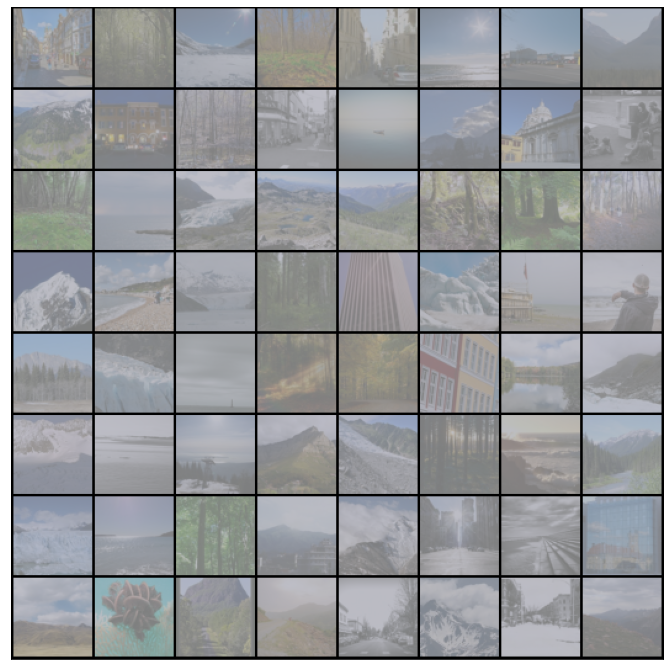

In [20]:
show_batches(train_dl)

## Choose device

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device("cpu")
    
# move tensor to the device
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        ## No of batches
        return len(self.dl)

In [22]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassification(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)    #generating predection
        loss=F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss.detach(),'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_loss=[x['val_loss'] for x in outputs]
        epoch_loss=torch.stack(batch_loss).mean()
        batch_acc=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['lrs'][-1],result['train_loss'],result['val_loss'],result['val_acc']))

In [23]:
device=get_default_device()
device

device(type='cpu')

In [24]:
train_dl=DeviceDataLoader(train_dl,device)
test_dl=DeviceDataLoader(test_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

## Build model

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet9(ImageClassification):
    def __init__(self, in_channels,num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels,64)
        self.conv2 = conv_block(64,128,pool=True)
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))
        self.conv3 = conv_block(128,256,pool=True)
        self.conv4 = conv_block(256,512,pool=True)
        self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                       nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)+out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [28]:
num_of_classes=len(dataset.classes)
num_of_classes

6

In [30]:
model=to_device(ResNet9(3,num_of_classes),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training model

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch)for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
history=[evaluate(model,val_dl)]
history

[{'val_loss': 1.790242075920105, 'val_acc': 0.16779892146587372}]

In [33]:
epochs=10
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [34]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,
                       val_dl,grad_clip=grad_clip,
                       opt_func=opt_func)
                  

Epoch [0], last_lr: 0.00277, train_loss: 1.0640, val_loss: 1.3741, val_acc: 0.5214
Epoch [1], last_lr: 0.00758, train_loss: 0.8025, val_loss: 4.1283, val_acc: 0.2284
Epoch [2], last_lr: 0.01000, train_loss: 0.7919, val_loss: 2.5492, val_acc: 0.4293
Epoch [3], last_lr: 0.00950, train_loss: 0.6641, val_loss: 0.5781, val_acc: 0.7871
Epoch [4], last_lr: 0.00812, train_loss: 0.5044, val_loss: 0.9755, val_acc: 0.6811
Epoch [5], last_lr: 0.00611, train_loss: 0.4475, val_loss: 0.4154, val_acc: 0.8541
Epoch [6], last_lr: 0.00389, train_loss: 0.3425, val_loss: 0.4152, val_acc: 0.8563
Epoch [7], last_lr: 0.00188, train_loss: 0.2828, val_loss: 0.3504, val_acc: 0.8751
Epoch [8], last_lr: 0.00050, train_loss: 0.2202, val_loss: 0.3226, val_acc: 0.8911
Epoch [9], last_lr: 0.00000, train_loss: 0.1962, val_loss: 0.3226, val_acc: 0.8901
CPU times: user 4h 4min 13s, sys: 31min 1s, total: 4h 35min 14s
Wall time: 1h 23min 46s


In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

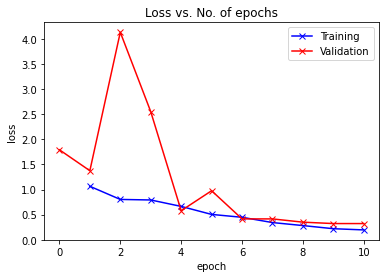

In [36]:
plot_losses(history)

In [37]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

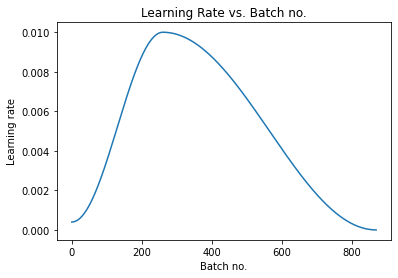

In [38]:
plot_lrs(history)

## Save model

In [39]:
torch.save(model.state_dict(),'model.pth')

## Model Evaluation

In [40]:
test_loader = DeviceDataLoader(test_dl,device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.3060871958732605, 'val_acc': 0.8918563723564148}